### Tools Integration in LangGraph

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_cohere import ChatCohere
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool # used to build custom tools

import requests
import random


In [2]:
load_dotenv()


True

In [3]:
llm = ChatCohere(model='command-r')


In [4]:
#tools creation
# pre-built tools
search_tool = DuckDuckGoSearchRun(region='us-en')


#custom tool
@tool
def calculator(first_number: float, second_number: float, operation: str) -> dict:
    """perform arithmetic operation on two numbers.
    valid operations: add, sub, mul, div"""
    try: 
        if operation == 'add':
            result = first_number + second_number
        elif operation == 'sub':
            result = first_number - second_number
        elif operation == 'mul':
            result = first_number * second_number
        elif operation == 'div':
            if second_number == 0:
                return {'error': 'division by zero can not be done'}
            result = first_number / second_number
        else:
            return {'error': f"Unsupported Operation {operation}"}
        
        return {'first_num': first_number, 'second_num': second_number, 'operation': operation, 'result': result}
    except Exception as e:
        return {'error': f'calculation failed. {str(e)}'}
            
@tool
def stock_price_retriever_tool(symbol: str) -> dict:
    """Fetch latest stock price of given symbol (eg. 'TSLA') using alpha vantage with API key in URL"""
    
    url = f'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=C9BO8HP247123YIA'
    r = requests.get(url)
    
    return r.json()


In [5]:
# tools list for llm
tools = [stock_price_retriever_tool, search_tool, calculator]

# making llm aware of tools
llm_with_tools = llm.bind_tools(tools)


In [6]:
# graph state
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]


In [7]:
# node definition
def chat_node(state: ChatState):
    """LLM node that may answer or can request a tool call"""
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    
    return {'messages': [response]}

tool_node = ToolNode(tools) # used to execute tool calls


In [8]:
# graph
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)


In [9]:
# edges
graph.add_edge(START, 'chat_node')

# conditional edge to tool node
graph.add_conditional_edges('chat_node', tools_condition) # condition is prebuilt, llm access tools if needed else provides the responses

# to polish the response generated using tools
graph.add_edge('tools', 'chat_node')


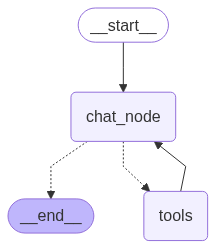

In [10]:
workflow = graph.compile()

workflow


In [11]:
# testing

response = workflow.invoke({'messages': [HumanMessage(content="hey, what's up?")]})

print(response['messages'][-1].content)


Hey there! Not much, haha. How about you? Is there anything you'd like to discuss?


In [12]:
# tool testing (calculator)
res = workflow.invoke({'messages': [HumanMessage('what is 34+34')]})
print(res['messages'][-1].content)


The answer to 34 + 34 is **68**.


In [13]:
# tool testing (stock price)
res = workflow.invoke({'messages': [HumanMessage('what is the stock price of google ?')]})
print(res['messages'][-1].content)


The latest stock price of Google (GOOG) is $213.53.


In [14]:
# tool testing (search)
res = workflow.invoke({'messages': [HumanMessage('what is the name of china president ?')]})
print(res['messages'][-1].content)


d:\LangGraph\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


The current president of China is Xi Jinping.


d:\LangGraph\.venv\Lib\site-packages\cohere\core\unchecked_base_model.py:165: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  if inner_type.__fields__[metadata.discriminant].default == objects_discriminant:


In [16]:
res = workflow.invoke({'messages': [HumanMessage('What is stock price of Nvidia, what will be the price in INR if 1$ = 80 INR')]})
print(res['messages'][-1].content)


The current stock price of Nvidia is $174.18. 

If 1$ = 80 INR, then the price of one share of Nvidia stock would be approximately **13,934.41 INR**.


d:\LangGraph\.venv\Lib\site-packages\cohere\core\unchecked_base_model.py:165: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  if inner_type.__fields__[metadata.discriminant].default == objects_discriminant:
d:\LangGraph\.venv\Lib\site-packages\cohere\core\unchecked_base_model.py:165: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use `model_fields` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  if inner_type.__fields__[metadata.discriminant].default == objects_discriminant:
